# Introduction

This project applies **Modern Portfolio Theory (MPT)**, developed by Harry Markowitz, to real financial data.  
The objective is to construct an **optimal portfolio** that balances expected return and risk, and to compare its performance against the market benchmark (S&P 500).

Key goals of the project:
- Understand the mathematical foundations of MPT (expected return, variance, Sharpe ratio, efficient frontier, and Capital Allocation Line).  
- Simulate thousands of random portfolios to approximate the efficient frontier.  
- Identify the **maximum Sharpe ratio portfolio** (tangency portfolio) and the **minimum volatility portfolio**.  
- Backtest the optimized portfolio against the **S&P 500** to evaluate its performance.  

Assets analyzed include: **NVDA, AAPL, GOOGL, MSFT, AMZN, META, and TSLA**.  

# Modern Portfolio Theory (MPT)

Modern Portfolio Theory (MPT), developed by **Harry Markowitz**, explains how investors can optimize their portfolios by balancing **expected return** and **risk** (measured as variance or standard deviation).

---

## 1. Expected Return of a Portfolio

The expected return of a portfolio is:

$$
\mathbb{E}[R_p] = \sum_{i=1}^n w_i \, \mathbb{E}[R_i]
$$

where:

- **$\mathbf{w_i =}$** weight of asset **$\mathbf{i}$** in the portfolio  
- **$\mathbf{R_i =}$** expected return of asset **$\mathbf{i}$**  
- **$\mathbf{\sum_i w_i = 1}$**

---

## 2. Portfolio Risk (Variance)

The variance of a portfolio is:

$$
\sigma_p^2 = \sum_{i=1}^n \sum_{j=1}^n w_i w_j \sigma_{ij}
$$

or, in matrix form:

$$
\sigma_p^2 = w^T \Sigma w
$$

where:
- $\mathbf{\Sigma}$ = covariance matrix of asset returns  
- $\mathbf{\sigma_p}$ = portfolio standard deviation (risk)  

---

## 3. Efficient Frontier

The **efficient frontier** is the set of portfolios that maximize expected return for a given risk level (or minimize risk for a given return).  

Optimization problem:

$$
\min_{w} \; w^T \Sigma w 
\quad \text{s.t.} \quad R^T w = \mu, \quad \mathbf{1}^T w = 1
$$

This gives the **minimum variance portfolio** for a target return $\mathbf{\mu}$.  
The collection of all such solutions forms the **efficient frontier**.

---

## 4. Capital Allocation Line (CAL)

If a **risk-free asset** with return $\mathbf{R_f}$ is available, combining it with the tangency portfolio $\mathbf{P}$ produces the **Capital Allocation Line (CAL):**

$$
\mathbb{E}[R_C] = R_f + \sigma_C \cdot 
\frac{\mathbb{E}[R_P] - R_f}{\sigma_P}
$$

where:
- $\mathbf{R_f}$ = risk-free rate  
- $\mathbf{\mathbb{E}[R_P]}, \mathbf{\sigma_P}$ = return and risk of tangency portfolio  
- $\mathbf{\mathbb{E}[R_C]}, \mathbf{\sigma_C}$ = return and risk of combined portfolio  

The CAL is a straight line starting at $(0, \mathbf{R_f})$ and tangent to the efficient frontier.

---

## 5. Sharpe Ratio

The **Sharpe ratio** measures risk-adjusted return:

$$
S = \frac{\mathbb{E}[R_p] - R_f}{\sigma_p}
$$

A higher Sharpe ratio means a more efficient portfolio (better return per unit of risk).

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Getting **data** and **plotting** the time series returns

[*********************100%***********************]  7 of 7 completed


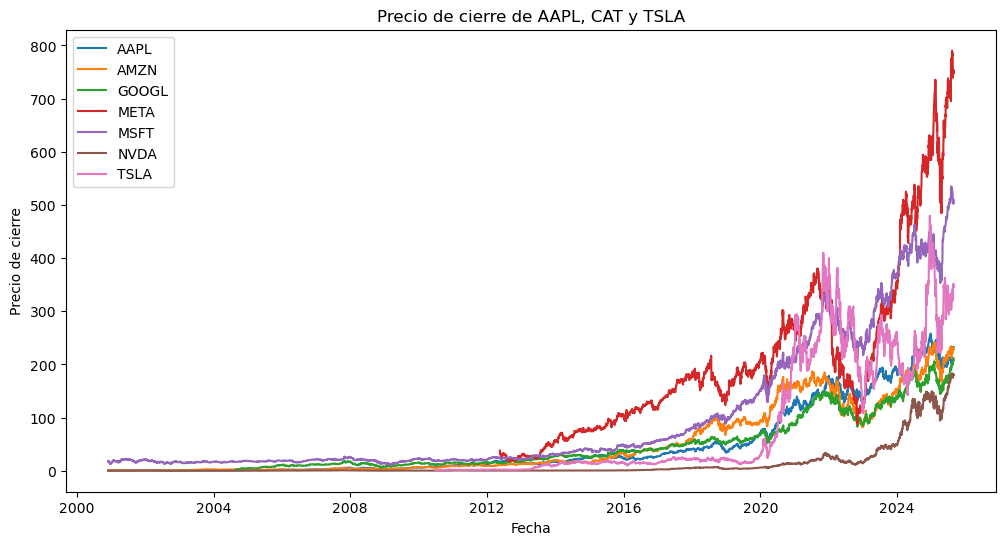

In [6]:
tickers = [
    "AAPL",   # Apple
    "MSFT",   # Microsoft
    "GOOGL",  # Alphabet (Google)
    "AMZN",   # Amazon
    "META",   # Meta (Facebook)
    "TSLA",   # Tesla
    "NVDA",   # NVIDIA
    #"BTC-USD",#Bitcoin  
]


df = yf.download(tickers, start="2000-12-01")["Close"]


plt.figure(figsize=(12, 6))

for i in df:
    plt.plot(df.index, df[i], label=i)

plt.legend()
plt.title("Precio de cierre de AAPL, CAT y TSLA")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre")
plt.show()

We can't really distinguish clear correlations so now we are going to plot daily returns and expect to see with assets move correlated with others

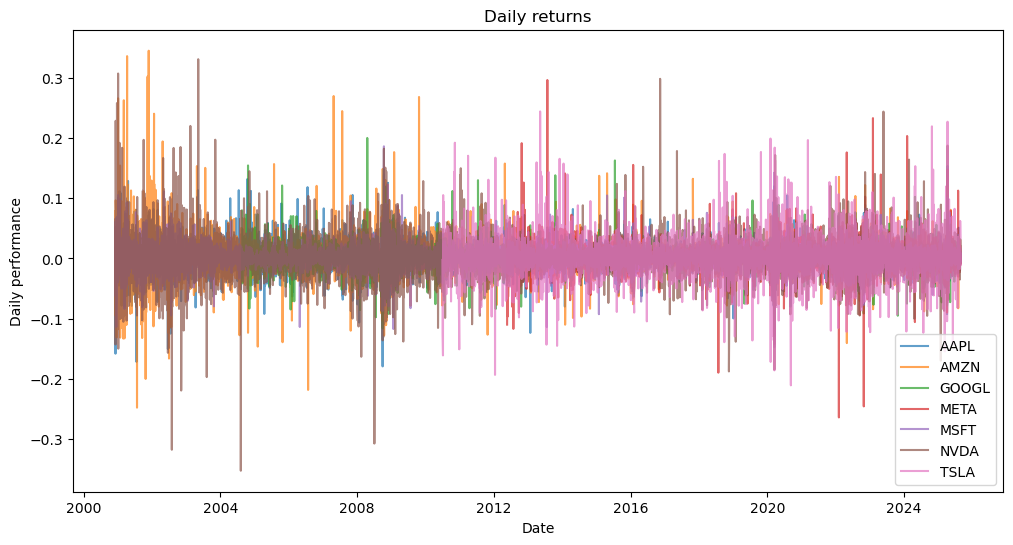

In [8]:
returns = df.pct_change()
plt.figure(figsize=(12,6))

for c in returns:
    plt.plot(returns.index, returns[c], label=c, alpha=0.7)

plt.legend()
plt.title("Daily returns")
plt.xlabel("Date")
plt.ylabel("Daily performance")
plt.show()

Now we can see how the correlation works within our tickets

## Portfolio Returns

First, consider the case of a portfolio with **two assets**.  
The expected return of the portfolio is given by:

$$
R_p = w_1 \mu_1 + w_2 \mu_2
$$

where:
- $\mathbf{w_1}, \mathbf{w_2}$ = portfolio weights of assets 1 and 2  
- $\mathbf{\mu_1}, \mathbf{\mu_2}$ = expected returns of assets 1 and 2  
- $w_1 + w_2 = 1$  

This represents the weighted average of the individual expected returns.

---

Following this we construct the **generalized portfolio returns function**.  
The expected return of a portfolio with \(n\) assets is:

$$
R_p = \sum_{i=1}^{n} w_i \mu_i
$$

where:
- $\mathbf{w_i}$ = weight of asset \(i\) in the portfolio  
- $\mathbf{\mu_i}$ = expected return of asset \(i\)  
- $\sum_i w_i = 1$  

This formula is implemented in the function `portfolio_annualised_performance`, which computes both the **annualized expected return** and the **annualized risk (standard deviation)** of the portfolio.

In [13]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix, periods_per_year=252):
    ret = np.dot(weights, mean_returns) * periods_per_year
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(periods_per_year)
    return std, ret

## Portfolio Simulation with Random Weights

To explore the risk–return trade-off, we generate many random portfolios using the **mean returns** and the **covariance matrix** of the assets:

- $\mathbf{\mu}$ = vector of mean (expected) returns of each asset  
- $\mathbf{\Sigma}$ = covariance matrix of asset returns  

Mathematically:
- The **expected portfolio return** is:

$$
R_p = w^T \mu
$$

- The **portfolio variance (risk)** is:

$$
\sigma_p^2 = w^T \Sigma w
$$

where $\mathbf{w}$ is the vector of portfolio weights.

---

We simulate $\mathbf{25{,}000}$ random portfolios, each with a different allocation $\mathbf{w}$, and compute:

1. **Expected return** $\mathbf{R_p}$  
2. **Risk** $\mathbf{\sigma_p}$  
3. **Sharpe ratio**:

$$
S = \frac{R_p - R_f}{\sigma_p}
$$

where $\mathbf{R_f = 0.0178}$ is the annual risk-free rate.

This process allows us to approximate the **efficient frontier** and identify the **tangency portfolio** (the one with maximum Sharpe ratio).

In [16]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    n_assets = len(mean_returns)                       
    results = np.zeros((3, num_portfolios))            # [std, return, sharpe]
    weights_record = np.zeros((num_portfolios, n_assets))

    for i in range(num_portfolios):
            weights = np.random.random(n_assets)
            weights /= np.sum(weights)
            weights_record[i, :] = weights

            std, ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
            results[0, i] = std
            results[1, i] = ret
            results[2, i] = (ret - risk_free_rate) / std

    return results, weights_record

In [18]:
mean_returns = returns.mean()
cov_matrix = returns.cov()

num_portfolios = 25000
risk_free_rate = 0.0178   # anual

results, weights_record = random_portfolios(
    num_portfolios, mean_returns, cov_matrix, risk_free_rate
)

In [19]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, results, weights_record, risk_free_rate, tickers=None):
    # tickers a partir de tus datos si no los pasas explícitamente
    if tickers is None:
        tickers = list(mean_returns.index)

    # índices de interés
    max_sharpe_idx = np.argmax(results[2])    # fila 2 = Sharpe
    min_vol_idx    = np.argmin(results[0])    # fila 0 = volatilidad

    # métricas de esos portafolios
    sdp, rp = results[0, max_sharpe_idx], results[1, max_sharpe_idx]
    sdp_min, rp_min = results[0, min_vol_idx], results[1, min_vol_idx]

    # asignaciones (en %)
    max_sharpe_weights = pd.Series(weights_record[max_sharpe_idx], index=tickers, name="allocation")*100
    min_vol_weights    = pd.Series(weights_record[min_vol_idx],    index=tickers, name="allocation")*100

    # prints
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp, 2))
    print("Annualised Volatility:", round(sdp, 2))
    print("\n")
    print(max_sharpe_weights.round(2).sort_values(ascending=False))

    print("\n" + "-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min, 2))
    print("Annualised Volatility:", round(sdp_min, 2))
    print("\n")
    print(min_vol_weights.round(2).sort_values(ascending=False))

    # gráfico de la nube
    plt.figure(figsize=(10, 7))
    sc = plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap="YlGnBu", s=10, alpha=0.3)
    plt.colorbar(sc, label="Sharpe Ratio")

    # marcar max Sharpe y min vol
    plt.scatter(sdp, rp, marker='*', s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min, rp_min, marker='*', s=500, label='Minimum volatility')

    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualised volatility')
    plt.ylabel('Annualised returns')
    plt.legend(labelspacing=0.8)
    plt.show()

---

## Efficient Frontier Visualization

The function `display_simulated_ef_with_random` uses the simulated portfolios to identify:

1. **Maximum Sharpe Ratio Portfolio (Tangency Portfolio):**  
   - Highest risk-adjusted return  
   - Found by maximizing  

   $$
   S = \frac{R_p - R_f}{\sigma_p}
   $$

2. **Minimum Volatility Portfolio:**  
   - Portfolio with the lowest risk $\mathbf{\sigma_p}$  

It then plots all simulated portfolios in the **risk–return space**, where:  
- Each point = one portfolio configuration  
- Color = Sharpe ratio  
- $\mathbf{*}$ markers = highlight the optimal portfolios  

This visual representation shows the **efficient frontier** and how the optimal portfolios compare to the rest.

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.37
Annualised Volatility: 0.3


Ticker
AAPL     30.02
TSLA     24.48
GOOGL    17.88
META     12.48
NVDA      8.12
AMZN      6.24
MSFT      0.77
Name: allocation, dtype: float64

--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.26
Annualised Volatility: 0.25


Ticker
MSFT     36.54
GOOGL    31.66
META     13.91
AAPL      9.14
TSLA      4.69
AMZN      2.68
NVDA      1.37
Name: allocation, dtype: float64


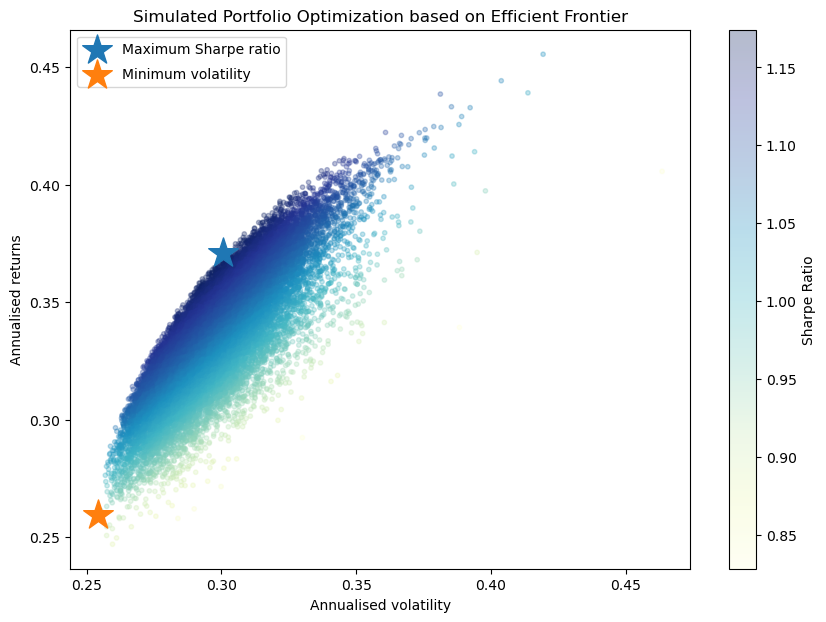

In [23]:
display_simulated_ef_with_random(
    mean_returns, cov_matrix, results, weights_record, risk_free_rate, tickers=df.columns)

## Portfolio Backtesting vs Benchmark

Finally, we evaluate the performance of the optimized portfolio compared to a market benchmark (the **S&P 500**).

1. **Portfolio weights** are chosen from the optimization process:

$$
w = \begin{bmatrix} 
48.34\% & 27.67\% & 10.52\% & 3.83\% & 3.47\% & 3.43\% & 1.57\% & 1.18\%
\end{bmatrix}
$$

for the assets [NVDA, AAPL, GOOGL, MSFT, AMZN, META, TSLA].

2. **Price data** is downloaded using Yahoo Finance, including the S&P 500 index (\(^GSPC\)).

3. **Returns are computed** for all assets and the benchmark:

$$
r_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$

4. The **portfolio return series** is constructed as the weighted sum:

$$
R_{p,t} = \sum_{i=1}^n w_i r_{i,t}
$$

5. **Cumulative wealth** (starting at 1) is computed as:

$$
W_t = \prod_{k=1}^{t} (1 + R_{p,k})
$$

6. Both the portfolio wealth and the S&P 500 wealth are normalized to the same starting point and plotted for comparison.

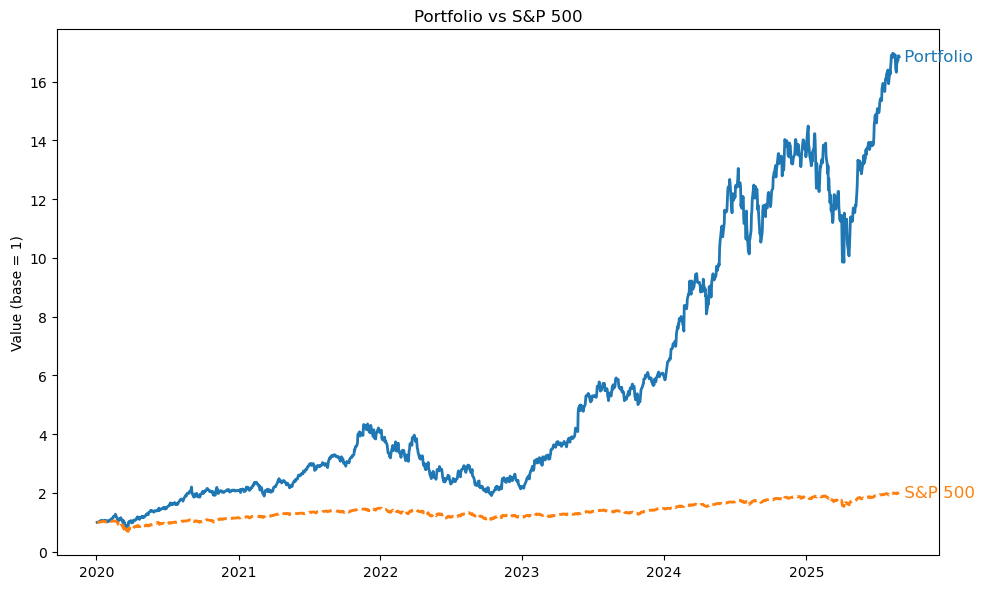

In [28]:
tickers = ["NVDA","AAPL","GOOGL","MSFT","AMZN","META","TSLA"]

# Matching 7 weights (drop BTC's 27.67), then normalize
w = np.array([48.34, 10.52, 3.83, 3.47, 3.43, 1.57, 1.18], dtype=float)
w = w / w.sum()
assert len(tickers) == len(w)

px = yf.download(tickers + ["^GSPC"], start="2020-01-01", progress=False)["Close"]
P, SPX = px[tickers], px["^GSPC"]

R = P.pct_change().dropna()
r_spx = SPX.pct_change().dropna().reindex(R.index)

wealth = (1 + R.dot(w)).cumprod()
wealth_ref = (1 + r_spx).cumprod()

wealth /= wealth.iloc[0]
wealth_ref /= wealth_ref.iloc[0]

plt.figure(figsize=(10,6))
l1, = plt.plot(wealth, linewidth=2, label="Portfolio")
l2, = plt.plot(wealth_ref, linestyle="--", linewidth=2, label="S&P 500")

# Inline labels (use line colors so they always match)
plt.text(wealth.index[-1], wealth.iloc[-1], " Portfolio", fontsize=12,
         color=l1.get_color(), va="center")
plt.text(wealth_ref.index[-1], wealth_ref.iloc[-1], " S&P 500", fontsize=12,
         color=l2.get_color(), va="center")

plt.ylabel("Value (base = 1)")
plt.title("Portfolio vs S&P 500")
plt.tight_layout()
plt.show()

# Conclusion

This project demonstrates how **Modern Portfolio Theory** can be applied in practice:

- By simulating many random portfolios, we approximate the **efficient frontier**, which represents the best possible trade-offs between risk and return.  
- The **maximum Sharpe ratio portfolio** was identified as the optimal risky portfolio, offering the highest risk-adjusted return.  
- A backtest against the **S&P 500** shows that the optimized portfolio **outperforms the benchmark** over the period analyzed, but with **higher volatility** due to heavy exposure to high-growth assets like NVIDIA and Bitcoin.  
- This highlights the classic **risk–return trade-off**: higher returns come at the cost of increased fluctuations.  

Overall, MPT provides a powerful foundation for portfolio construction, but its limitations (normality assumptions, static correlations, estimation errors) remind us to complement it with robust risk management and practical considerations.

# Precautions and Limitations of MPT

While Modern Portfolio Theory (MPT) provides a solid mathematical framework for diversification and risk–return optimization, there are several practical considerations to keep in mind:

1. **Assumption of Normal Returns**  
   - MPT assumes that asset returns are normally distributed.  
   - In reality, returns often show **fat tails** (extreme events) and **skewness**, meaning risk may be underestimated.

2. **Static Correlations**  
   - MPT relies on historical correlations and covariances.  
   - Correlations between assets can change significantly, especially during **market crises**, reducing diversification benefits when they are most needed.

3. **Estimation Errors**  
   - Portfolio optimization is highly sensitive to inputs (expected returns, volatilities, covariances).  
   - Small estimation errors can lead to **unstable or unrealistic allocations**.

4. **No Transaction Costs or Taxes**  
   - The model assumes frictionless markets, but in practice, frequent rebalancing incurs **transaction costs** and **tax implications**.

5. **Single Period Framework**  
   - MPT is a one-period model and does not account for **dynamic strategies** or investor time horizons.  
   - Real investors face changing preferences and market conditions.

6. **Ignores Other Risks**  
   - Focuses only on market risk (volatility).  
   - Does not capture **liquidity risk, credit risk, or systemic risk**, which may be significant in practice.

---

 **Takeaway:**  
MPT is a valuable starting point for understanding diversification and portfolio construction.  
However, investors should combine it with **robust risk management**, **stress testing**, and awareness of its assumptions to avoid over-reliance on the model.

# Next Steps

- **Introduce Volatility Analysis:**  
  Extend the project by incorporating volatility tying theory

- **Build a Dynamic App with Streamlit:**  
  Transform this notebook into an interactive web application using the **Streamlit** library, allowing users to select assets, adjust parameters (e.g., risk-free rate, number of simulations), and visualize portfolio optimization results in real time.